## Group No 8

## Group Member Names:

1. Rekha N - 2022dc04058
2. Prabhakaran J - 2022dc04186
3. Sujitha J - 2022dc04059


In [1]:
!pip install opencv-python

In [2]:
pip install tensorflow

# 1. Import the required libraries

In [1]:
import os,cv2
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import cv2.ximgproc

# 2. Data Acquisition

#Dataset link: https://github.com/datitran/raccoon_dataset/tree/master

In [2]:
df = pd.read_csv("D:/BITS/Semester3/DL/Assignment/Assignment2/raccoon_dataset-master/data/train_labels.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [3]:
path = "D:/BITS/Semester3/DL/Assignment/Assignment2/raccoon_dataset-master/images"

# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

raccoon-17.jpg


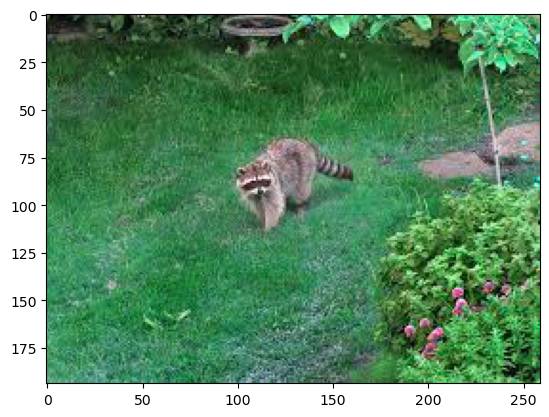

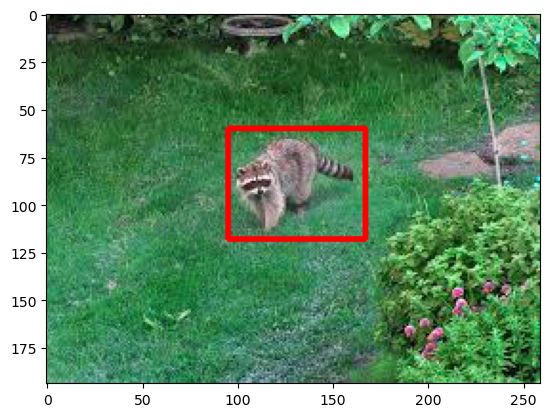

In [4]:
for i in np.arange(df.shape[0]):
    filename = df["filename"][i].split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    plt.imshow(img)
    x1 = int(df["xmin"][i])
    y1 = int(df["ymin"][i])
    x2 = int(df["xmax"][i])
    y2 = int(df["ymax"][i])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

In [5]:
import cv2
print(cv2.__version__)
print(hasattr(cv2, 'ximgproc'))

4.10.0
True


In [10]:
pip install opencv-contrib-python --user


  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

[[ 33 512  63  61]
 [508 409  12  20]
 [368 336 164   6]
 ...
 [192 240 608 333]
 [ 96   0 704 345]
 [ 96   0 704 191]]


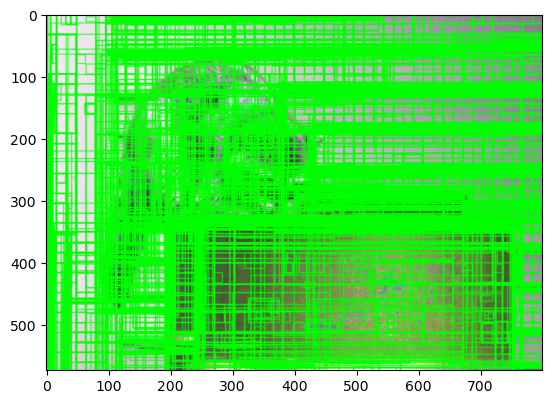

In [7]:
im = cv2.imread(os.path.join(path,"raccoon-2.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(rects)
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

## 4. Deep Neural Network Architecture

## 4.1 Design the architecture that you will be using

 CNN 

In [8]:
train_images=[]
train_labels=[]

In [9]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [10]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [11]:
# creating the regional proposal for images
for i in np.arange(df.shape[0]):
    try:
        filename = df["filename"][i].split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        gtvalues=[]
        x1 = int(df["xmin"][i])
        y1 = int(df["ymin"][i])
        x2 = int(df["xmax"][i])
        y2 = int(df["ymax"][i])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e, result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

raccoon-17.jpg
raccoon-11.jpg
raccoon-63.jpg
raccoon-63.jpg
raccoon-60.jpg
raccoon-69.jpg
raccoon-180.jpg
raccoon-200.jpg
raccoon-141.jpg
raccoon-19.jpg
raccoon-84.jpg
raccoon-124.jpg
raccoon-182.jpg
raccoon-111.jpg
raccoon-91.jpg
raccoon-79.jpg
raccoon-93.jpg
raccoon-20.jpg
raccoon-42.jpg
raccoon-139.jpg
raccoon-58.jpg
raccoon-71.jpg
raccoon-183.jpg
raccoon-1.jpg
raccoon-169.jpg
raccoon-82.jpg
raccoon-4.jpg
raccoon-101.jpg
raccoon-10.jpg
raccoon-166.jpg
raccoon-184.jpg
raccoon-38.jpg
raccoon-120.jpg
raccoon-142.jpg
raccoon-149.jpg
raccoon-51.jpg
raccoon-43.jpg
raccoon-123.jpg
inside
raccoon-66.jpg
raccoon-9.jpg
raccoon-178.jpg
raccoon-47.jpg
raccoon-167.jpg
raccoon-54.jpg
raccoon-77.jpg
raccoon-155.jpg
raccoon-89.jpg
raccoon-153.jpg
raccoon-179.jpg
raccoon-115.jpg
raccoon-64.jpg
raccoon-56.jpg
inside
raccoon-44.jpg
raccoon-39.jpg
raccoon-26.jpg
raccoon-162.jpg
raccoon-170.jpg
raccoon-187.jpg
raccoon-131.jpg
raccoon-174.jpg
raccoon-92.jpg
raccoon-193.jpg
raccoon-138.jpg
raccoon-157.jpg

In [12]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [13]:
X_new.shape

(6401, 224, 224, 3)

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters


In [14]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications.vgg16 import VGG16

In [15]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 211s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [17]:
X= vggmodel.layers[-2].output

In [18]:
predictions = Dense(2, activation="softmax")(X)

In [19]:
model_final = Model(vggmodel.input, predictions)

In [20]:
opt = Adam(learning_rate=0.0001)

In [21]:
model_final.compile(loss = categorical_crossentropy, optimizer = opt, metrics=["acc"])

In [22]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 126,633,474 (483.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# 5. Training the model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [24]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [25]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [26]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5760, 224, 224, 3) (641, 224, 224, 3) (5760, 2) (641, 2)


In [27]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
#checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [30]:
#hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])
#hist = model_final.fit(X_new, Y, epochs= 10, validation_split=0.1, callbacks=[checkpoint,early])
hist = model_final.fit(x=traindata, epochs=5, validation_data=testdata, callbacks=[checkpoint, early])


Epoch 1/5


C:\Users\Sujitha\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.9547 - loss: 0.3709
Epoch 1: val_loss improved from inf to 0.04746, saving model to ieeercnn_vgg16_1.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 1842s 10s/step - acc: 0.9549 - loss: 0.3697 - val_acc: 0.9844 - val_loss: 0.0475
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.9851 - loss: 0.0463
Epoch 2: val_loss improved from 0.04746 to 0.03624, saving model to ieeercnn_vgg16_1.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 1144s 6s/step - acc: 0.9851 - loss: 0.0464 - val_acc: 0.9891 - val_loss: 0.0362
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.9856 - loss: 0.0421
Epoch 3: val_loss did not improve from 0.03624
180/180 ━━━━━━━━━━━━━━━━━━━━ 1095s 6s/step - acc: 0.9856 - loss: 0.0421 - val_acc: 0.9750 - val_loss: 0.1096
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.9888 - loss: 0.0364
Epoch 4: val_loss did not improve from 0.03624
180/180 ━━━━━━━━━━━━━━━━━━━━ 1213s 7s/step - acc: 0.9888 - loss: 0.0364 - val_acc: 0.9828 - va

# 6. Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
not plane


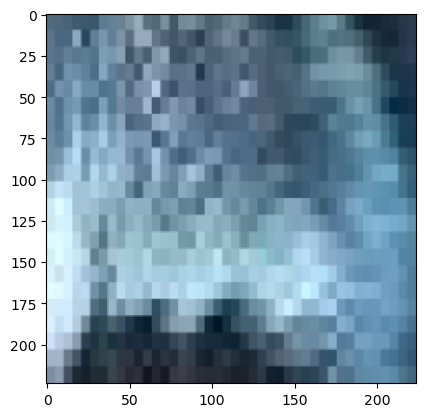

In [32]:
im = X_test[400]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [33]:
test_df = pd.read_csv("D:/BITS/Semester3/DL/Assignment/Assignment2/raccoon_dataset-master/data/test_labels.csv")
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-146.jpg,275,183,raccoon,4,4,271,180
1,raccoon-105.jpg,720,960,raccoon,250,49,714,869
2,raccoon-143.jpg,259,194,raccoon,17,29,238,162
3,raccoon-57.jpg,640,425,raccoon,82,6,638,423
4,raccoon-68.jpg,640,423,raccoon,1,24,517,423


raccoon-146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━

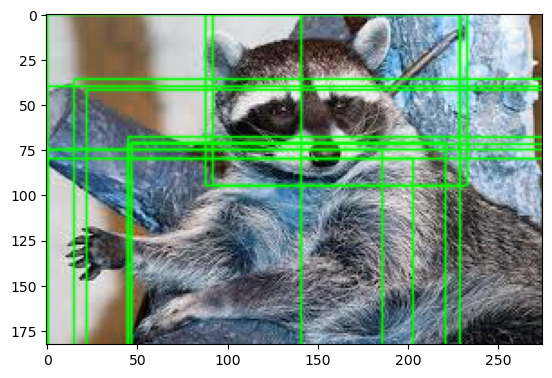

In [34]:
for i in np.arange(test_df.shape[0]):
    filename = test_df["filename"][i].split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    #plt.imshow(img)
    for e,result in enumerate(ssresults):
        if e < 2000:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            if out[0][0] > 0.90:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)
    break

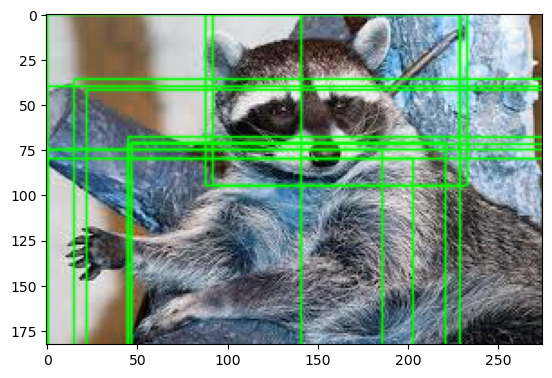

In [35]:
plt.figure()
plt.imshow(imout)

# 7. Report the result

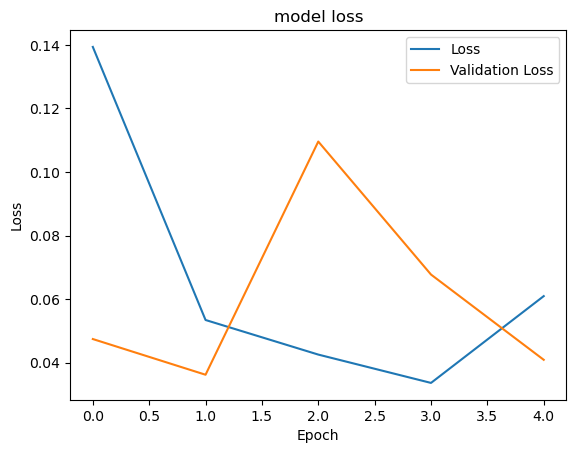

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')